In [2]:
!pip -q install -U "bitsandbytes" "accelerate" "transformers"
print("DONE. Now restart the runtime (Runtime -> Restart runtime), then run Cell B.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 31.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 112.5 MB/s eta 0:00:0000:010:01
DONE. Now restart the runtime (Runtime -> Restart runtime), then run Cell B.


In [1]:
%%writefile data_manager.py
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import random

class RealWorldDataset(Dataset):
    def __init__(self, hf_data, task_type):
        self.data = hf_data
        self.task_type = task_type
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # --- MAPPING VISUAL TASKS TO TEXT PROXIES ---
        
        # 1. Relation Tasks (Proxy for Visual Relation) -> MNLI
        if self.task_type == "relation":
            premise = item['premise']
            hypothesis = item['hypothesis']
            # Labels: 0=entailment, 1=neutral, 2=contradiction
            label_map = {0: "Yes", 1: "Maybe", 2: "No"}
            text = f"Premise: {premise}\nHypothesis: {hypothesis}\nDoes the premise imply the hypothesis? Answer:"
            label = label_map.get(item['label'], "Unknown")

        # 2. Reasoning Tasks (Proxy for Multi-modal Reasoning) -> CommonsenseQA
        elif self.task_type == "reasoning":
            question = item['question']
            choices = item['choices'] # dict with 'label' and 'text' lists
            # Format choices nicely
            choice_str = ", ".join([f"({l}) {t}" for l, t in zip(choices['label'], choices['text'])])
            text = f"Question: {question}\nOptions: {choice_str}\nChoose the best answer:"
            label = item['answerKey']

        # 3. Fact Retrieval (Proxy for VQA) -> SQuAD
        elif self.task_type == "vqa_proxy":
            context = item['context']
            question = item['question']
            text = f"Context: {context}\nQuestion: {question}\nAnswer:"
            # SQuAD answers are lists, take the first valid one
            label = item['answers']['text'][0] if len(item['answers']['text']) > 0 else "Unknown"

        # 4. Math/Logic (Proxy for Complex Reasoning) -> GSM8K
        elif self.task_type == "math":
            question = item['question']
            text = f"Solve this step-by-step: {question}\nAnswer:"
            label = item['answer']

        return f"{text} {label}"

class DataManager:
    def __init__(self, batch_size=4):
        self.batch_size = batch_size
        
    def setup_real_world_benchmark(self):
        print("--- Initializing 'Scaled-Up' Benchmark (Mimicking DRAKE) ---")
        
        datasets = []
        
        # --- Task Group A: Relation Understanding (Clients 0, 1, 2) ---
        # Mimics: Fashion Relation, Spatial Relation
        print("Loading MNLI (Relation Proxy)...")
        ds_mnli = load_dataset("glue", "mnli", split="train[:1000]")
        # Partition 1000 samples into 3 chunks
        datasets.append(RealWorldDataset(ds_mnli.select(range(0, 300)), "relation"))
        datasets.append(RealWorldDataset(ds_mnli.select(range(300, 600)), "relation"))
        datasets.append(RealWorldDataset(ds_mnli.select(range(600, 900)), "relation"))

        # --- Task Group B: Reasoning (Clients 3, 4, 5) ---
        # Mimics: Visual Figurative, Context-dependent Reasoning
        print("Loading CommonsenseQA (Reasoning Proxy)...")
        ds_cqa = load_dataset("tau/commonsense_qa", split="train[:1000]")
        datasets.append(RealWorldDataset(ds_cqa.select(range(0, 300)), "reasoning"))
        datasets.append(RealWorldDataset(ds_cqa.select(range(300, 600)), "reasoning"))
        datasets.append(RealWorldDataset(ds_cqa.select(range(600, 900)), "reasoning"))

        # --- Task Group C: Fact Retrieval (Clients 6, 7, 8) ---
        # Mimics: General VQA, TextVQA
        print("Loading SQuAD (VQA Proxy)...")
        ds_squad = load_dataset("rajpurkar/squad", split="train[:1000]")
        datasets.append(RealWorldDataset(ds_squad.select(range(0, 300)), "vqa_proxy"))
        datasets.append(RealWorldDataset(ds_squad.select(range(300, 600)), "vqa_proxy"))
        datasets.append(RealWorldDataset(ds_squad.select(range(600, 900)), "vqa_proxy"))

        # --- Task Group D: Complex Logic (Client 9 - The 'Expert') ---
        # Mimics: Unseen Tasks / Expert Domains
        print("Loading GSM8K (Math Expert)...")
        ds_math = load_dataset("gsm8k", "main", split="train[:300]")
        datasets.append(RealWorldDataset(ds_math, "math"))
        
        print(f"✅ Created 10 Clients covering 4 Distinct Cognitive Domains.")
        return datasets

Writing data_manager.py


In [2]:
# --- 0. INSTALL CHECK ---
try:
    import bitsandbytes
except ImportError:
    print("Installing dependencies... Please restart runtime after this finishes!")
    !pip install -q -U bitsandbytes accelerate
    print("DONE. PLEASE RESTART RUNTIME NOW.")
    exit()

import os, gc, random, hashlib, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from data_manager import DataManager

# --- CONFIGURATION (TUNED FOR CONVERGENCE) ---
ROUNDS = 50
# Boosted LR: 2e-4 was too slow for 50 rounds. 5e-4 or 1e-3 is better for LoRA.
INITIAL_LR = 1e-3
FINAL_LR = 1e-5
DECAY_RATE = (FINAL_LR / INITIAL_LR) ** (1 / ROUNDS)

MODEL_SMALL = "Qwen/Qwen2.5-0.5B-Instruct"
MODEL_LARGE = "Qwen/Qwen2.5-1.5B-Instruct"
MODEL_SHARED_WS = "Qwen/Qwen2.5-0.5B-Instruct"
DEVICE_MAP_ARG = "auto" if torch.cuda.is_available() else None

# Training Intensity
TRAIN_SAMPLES = 32      # Increased batch size coverage
TRAIN_STEPS = 15        # Enough steps to move weights
VAL_SAMPLES = 32        # Validating on more data reduces noise

# Adapter Scaling
RANK = 16
ALPHA = 32              # High alpha = Stronger signal
B_SCALE = 0.1           # CRITICAL FIX: 0.1 allows gradients to flow. 0.001 kills them.

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_all(42)

In [9]:
# --- ALIGNMENT BANK ---
AB_BANK = {}

def get_aligned_interface(layer_name, r, in_features, out_features):
    key = f"{layer_name}_{r}_{in_features}_{out_features}"
    if key not in AB_BANK:
        seed_int = int(hashlib.sha256(key.encode("utf-8")).hexdigest(), 16) % (2**32)
        g = torch.Generator().manual_seed(seed_int)

        # A: Random Orthogonal
        A_init = torch.randn(r, in_features, generator=g)
        Q_a, _ = torch.linalg.qr(A_init.T, mode="reduced")
        A = Q_a.T.contiguous()

        # B: Small Orthogonal (BOOSTED SCALE)
        B_init = torch.randn(out_features, r, generator=g)
        Q_b, _ = torch.linalg.qr(B_init, mode="reduced")
        # FIX: Multiplied by 0.1 instead of 0.001
        B = (Q_b.contiguous() * B_SCALE)

        AB_BANK[key] = {"A": A, "B": B}
    return AB_BANK[key]["A"], AB_BANK[key]["B"]

# --- TRUE PQ-LORA LAYER ---
class TruePQLoRALayer(nn.Module):
    def __init__(self, in_features, out_features, r=16, alpha=16, dropout=0.1, init_A=None, init_B=None):
        super().__init__()
        self.r = r
        self.scaling = alpha / r
        if init_A is None or init_B is None: raise ValueError("Need injected A/B")
        
        self.register_buffer("A", init_A.clone())
        self.register_buffer("B", init_B.clone())
        self.P_local = nn.Parameter(torch.eye(r))
        self.Q_local = nn.Parameter(torch.zeros(r))
        self.beta = nn.Parameter(torch.tensor(0.5))
        self.register_buffer("P_global", torch.eye(r))
        self.register_buffer("Q_global", torch.zeros(r))
        self.dropout = nn.Dropout(p=dropout)

    def update_global_weights(self, P, Q):
        with torch.no_grad():
            self.P_global.copy_(P)
            self.Q_global.copy_(Q)

    def forward(self, x):
        u = F.linear(x, self.A)
        u_local = F.linear(u, self.P_local, self.Q_local)
        u_global = F.linear(u, self.P_global, self.Q_global)
        u_mix = (1 - self.beta) * u_local + self.beta * u_global
        delta = F.linear(u_mix, self.B)
        return self.dropout(delta) * self.scaling

# --- SERVER ---
class ServerScientific:
    def __init__(self, num_clients):
        self.num_clients = num_clients
        self.tmp_dir = "server_sci_tmp"
        os.makedirs(self.tmp_dir, exist_ok=True)
        self.history_weights = []

    def aggregate(self, client_updates):
        for i, up in enumerate(client_updates):
            torch.save(up, f"{self.tmp_dir}/update_{i}.pt")
        del client_updates; gc.collect()

        vectors = []
        for i in range(self.num_clients):
            data = torch.load(f"{self.tmp_dir}/update_{i}.pt", map_location="cpu")
            vectors.append(data["vector"])
            del data

        max_len = max(v.shape[0] for v in vectors)
        padded = [F.pad(v, (0, max_len - v.shape[0])) for v in vectors]
        V = torch.stack(padded)
        V = F.normalize(V, p=2, dim=1)
        sim = torch.mm(V, V.t())
        weights = F.softmax(sim / 0.5, dim=1)
        self.history_weights.append(weights.detach().cpu().numpy())

        # Aggregate Weights
        meta = torch.load(f"{self.tmp_dir}/update_0.pt", map_location="cpu")
        layer_names = list(meta["weights"].keys())
        del meta

        personalized_globals = []
        for i in range(self.num_clients):
            wi = weights[i]
            gdict = {ln: {"P": 0, "Q": 0} for ln in layer_names}
            for j in range(self.num_clients):
                w = float(wi[j].item())
                if w <= 1e-4: continue
                data = torch.load(f"{self.tmp_dir}/update_{j}.pt", map_location="cpu")
                wdict = data["weights"]
                for ln in layer_names:
                    if ln in wdict:
                        if isinstance(gdict[ln]["P"], int):
                            gdict[ln]["P"] = wdict[ln]["P"] * w
                            gdict[ln]["Q"] = wdict[ln]["Q"] * w
                        else:
                            gdict[ln]["P"] += wdict[ln]["P"] * w
                            gdict[ln]["Q"] += wdict[ln]["Q"] * w
                del data
            personalized_globals.append(gdict)
            gc.collect()
        return personalized_globals

# --- CLIENT ---
class FederatedClientScientific:
    def __init__(self, client_id, model_type, dataset):
        self.id = client_id
        self.model_type = model_type
        self.dataset = dataset
        self.r = RANK
        self.history = {"train_loss": [], "val_loss": []}
        self.local_state = {}
        self.ema_grad = None
        
        n = len(dataset)
        val_size = min(VAL_SAMPLES, max(4, int(n * 0.1)))
        self.val_indices = list(range(n - val_size, n))
        self.train_indices = list(range(0, n - val_size))

    def get_model_name(self):
        return MODEL_SMALL if self.model_type == "small" else MODEL_LARGE

    def _get_bnb_config(self):
        return BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)

    def execute_round(self, global_weights_dict, current_round, mode="repsim"):
        lr = INITIAL_LR * (DECAY_RATE ** current_round)
        model_name = self.get_model_name()
        tok = AutoTokenizer.from_pretrained(model_name)
        if tok.pad_token is None: tok.pad_token = tok.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=self._get_bnb_config(), device_map=DEVICE_MAP_ARG)
        model.gradient_checkpointing_enable(); model.eval()
        
        embed_device = model.model.embed_tokens.weight.device if hasattr(model, "model") else model.device

        # Inject Adapters
        target_layers = range(len(model.model.layers) - 4, len(model.model.layers))
        active = nn.ModuleDict()
        hooks = []
        
        def get_hook(name):
            def hfn(mod, inp, out):
                h = out[0] if isinstance(out, tuple) else out
                x = inp[0].to(torch.float32)
                delta = active[name](x).to(h.dtype)
                return (h + delta,) + out[1:] if isinstance(out, tuple) else h + delta
            return hfn

        for layer_idx in target_layers:
            block = model.model.layers[layer_idx]
            targets = {f"l{layer_idx}_q": block.self_attn.q_proj, f"l{layer_idx}_v": block.self_attn.v_proj}
            for name, mod in targets.items():
                dev = mod.weight.device
                A, B = get_aligned_interface(name, self.r, mod.in_features, mod.out_features)
                pq = TruePQLoRALayer(mod.in_features, mod.out_features, r=self.r, alpha=ALPHA, init_A=A, init_B=B).to(dev, dtype=torch.float32)
                
                if name in self.local_state:
                    with torch.no_grad():
                        pq.P_local.copy_(self.local_state[name]["P"])
                        pq.Q_local.copy_(self.local_state[name]["Q"])
                        pq.beta.copy_(self.local_state[name]["beta"])
                
                if global_weights_dict and name in global_weights_dict:
                    pq.update_global_weights(global_weights_dict[name]["P"].to(dev), global_weights_dict[name]["Q"].to(dev))

                active[name] = pq
                hooks.append(mod.register_forward_hook(get_hook(name)))

        # Train
        idx = random.sample(self.train_indices, min(8, len(self.train_indices)))
        inputs = tok([self.dataset[i] for i in idx], return_tensors="pt", padding=True, truncation=True, max_length=128).to(embed_device)
        opt = optim.AdamW(active.parameters(), lr=lr)
        model.train()
        total_loss = 0
        for _ in range(TRAIN_STEPS):
            opt.zero_grad()
            out = model(**inputs, labels=inputs.input_ids)
            loss = out.loss
            loss.backward()
            opt.step()
            total_loss += loss.item()
        
        self.history["train_loss"].append(total_loss / TRAIN_STEPS)
        self.local_state = {n: {"P": p.P_local.detach().cpu(), "Q": p.Q_local.detach().cpu(), "beta": p.beta.detach().cpu()} for n, p in active.items()}

        # Val (Answer Masked)
        model.eval()
        v_idx = self.val_indices
        v_inputs = tok([self.dataset[i] for i in v_idx], return_tensors="pt", padding=True, truncation=True, max_length=128).to(embed_device)
        with torch.no_grad():
            vloss = model(**v_inputs, labels=v_inputs.input_ids).loss.item()
        self.history["val_loss"].append(vloss)
        
        if self.id in [0, 9]: print(f"  [Round {current_round}] C{self.id} | Train: {total_loss/TRAIN_STEPS:.3f} | Val: {vloss:.3f}")

        # Probe
        probe_texts = [self.dataset[i] for i in v_idx[:4]]
        for h in hooks: h.remove()
        
        vector = None
        # Reuse if architecture matches
        if model_name == MODEL_SHARED_WS:
            vector = self._compute_probe(model, tok, probe_texts, embed_device, mode)
        else:
            del model, opt, inputs; gc.collect(); torch.cuda.empty_cache()
            model2 = AutoModelForCausalLM.from_pretrained(MODEL_SHARED_WS, quantization_config=self._get_bnb_config(), device_map=DEVICE_MAP_ARG)
            model2.eval()
            dev2 = model2.model.embed_tokens.weight.device if hasattr(model2, "model") else model2.device
            vector = self._compute_probe(model2, tok, probe_texts, dev2, mode)
            del model2
            
        gc.collect(); torch.cuda.empty_cache()
        return {"weights": self.local_state, "vector": vector}

    def _compute_probe(self, model, tok, texts, device, mode):
        inputs = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        if mode == "grad":
            model.zero_grad()
            model(input_ids=inputs.input_ids, labels=inputs.input_ids).loss.backward()
            grad = model.lm_head.weight.grad.detach().cpu().flatten()[::20]
            
            if self.ema_grad is None: self.ema_grad = grad
            else: self.ema_grad = 0.5 * self.ema_grad + 0.5 * grad
            g = self.ema_grad + torch.randn_like(self.ema_grad) * 1e-4
            k = int(len(g) * 0.4); thr = torch.topk(torch.abs(g), k)[0][-1]
            return (g * (torch.abs(g) >= thr).float()).float()
        else:
            with torch.no_grad():
                return model(input_ids=inputs.input_ids, output_hidden_states=True).hidden_states[-1].mean(dim=(0, 1)).cpu().float()

## Main Training Loop

In [19]:
# -----------------------------
# 7) TRAIN BOTH (MeanRep + SimGrad)
# -----------------------------
# print("Rounds: ", ROUNDS)
def train_both(datasets, rounds=ROUNDS):
    # --- 1. MeanRep (Ours) ---
    print("\n=== STARTING MEAN-REP (Answer-Masked Val) ===")
    server_repsim = ServerScientific(num_clients=10)
    # Re-initialize clients to ensure clean state
    clients_repsim = [FederatedClientScientific(i, "small" if i < 5 else "large", datasets[i]) for i in range(10)]
    globals_rep = [None] * 10

    for r in range(rounds):
        if r % 10 == 0:
            print(f"Processing Round {r}...")
        updates = []
        for i, c in enumerate(clients_repsim):
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # mode="repsim" triggers Mean Pooling signature
            updates.append(c.execute_round(globals_rep[i], current_round=r, mode="repsim"))
        globals_rep = server_repsim.aggregate(updates)

    # --- 2. SimGrad (Baseline) ---
    print("\n=== STARTING SIMGRAD (Answer-Masked Val) ===")
    server_grad = ServerScientific(num_clients=10)
    # Re-initialize clients to ensure clean state
    clients_grad = [FederatedClientScientific(i, "small" if i < 5 else "large", datasets[i]) for i in range(10)]
    globals_grad = [None] * 10

    for r in range(rounds):
        if r % 10 == 0:
            print(f"Processing Round {r}...")
        updates = []
        for i, c in enumerate(clients_grad):
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # mode="grad" triggers Gradient + Sanitization signature
            updates.append(c.execute_round(globals_grad[i], current_round=r, mode="grad"))
        globals_grad = server_grad.aggregate(updates)

    print("\nFinished training both.")
    return clients_grad, clients_repsim, server_grad, server_repsim

# --- EXECUTE ---
# Ensure datasets exists (from previous setup)
if 'datasets' not in locals():
    dm = DataManager()
    datasets = dm.setup_real_world_benchmark()

clients_grad, clients_repsim, server_grad, server_repsim = train_both(datasets, rounds=ROUNDS)

Rounds:  50

=== STARTING MEAN-REP (Answer-Masked Val) ===
Processing Round 0...
  [Round 0] C0 | Train: 9.291 | Val: 9.800
  [Round 0] C9 | Train: 1.536 | Val: 1.214
  [Round 1] C0 | Train: 9.608 | Val: 9.714
  [Round 1] C9 | Train: 1.240 | Val: 1.213
  [Round 2] C0 | Train: 8.729 | Val: 9.650
  [Round 2] C9 | Train: 1.382 | Val: 1.213
  [Round 3] C0 | Train: 8.628 | Val: 9.597
  [Round 3] C9 | Train: 1.820 | Val: 1.212
  [Round 4] C0 | Train: 9.851 | Val: 9.545
  [Round 4] C9 | Train: 1.322 | Val: 1.212
  [Round 5] C0 | Train: 7.809 | Val: 9.493
  [Round 5] C9 | Train: 1.185 | Val: 1.212
  [Round 6] C0 | Train: 6.910 | Val: 9.458
  [Round 6] C9 | Train: 1.370 | Val: 1.211
  [Round 7] C0 | Train: 7.971 | Val: 9.407
  [Round 7] C9 | Train: 1.280 | Val: 1.211
  [Round 8] C0 | Train: 8.058 | Val: 9.368
  [Round 8] C9 | Train: 1.306 | Val: 1.210
  [Round 9] C0 | Train: 9.061 | Val: 9.324
  [Round 9] C9 | Train: 1.257 | Val: 1.210
Processing Round 10...
  [Round 10] C0 | Train: 9.344 | Val

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DEFINE GROUND TRUTH GROUPS ---
GROUPS = {
    "Relation (MNLI)":  [0, 1, 2],
    "Reasoning (CQA)":  [3, 4, 5],
    "VQA (SQuAD)":      [6, 7],
    "Math (GSM8K)":     [8, 9]
}
client_to_group = {i: g for g, ids in GROUPS.items() for i in ids}

# --- 2. DEFINE METRIC FUNCTIONS ---
def get_in_domain_mass(history_weights):
    """Calculates average weight assigned to peers in the same task group."""
    mass = []
    for W in history_weights:
        total = 0.0
        for i in range(10):
            peers = GROUPS[client_to_group[i]]
            total += float(np.sum(W[i, peers]))
        mass.append(total / 10.0)
    return np.array(mass)

def get_avg_entropy(history_weights, eps=1e-12):
    """Calculates row-wise entropy (Confidence). Lower = More Selective."""
    ent = []
    for W in history_weights:
        P = np.clip(W, eps, 1.0)
        H = -np.sum(P * np.log(P), axis=1)
        ent.append(float(np.mean(H)))
    return np.array(ent)

def get_weight_drift(history_weights):
    """Calculates Frobenius norm of weight change between rounds (Stability)."""
    drifts = []
    for t in range(1, len(history_weights)):
        drifts.append(float(np.linalg.norm(history_weights[t] - history_weights[t-1])))
    return np.array(drifts)

print("✅ Metrics initialized. Ready to plot.")

✅ Metrics initialized. Ready to plot.



      PART 1: SHOWCASING THE ISSUE



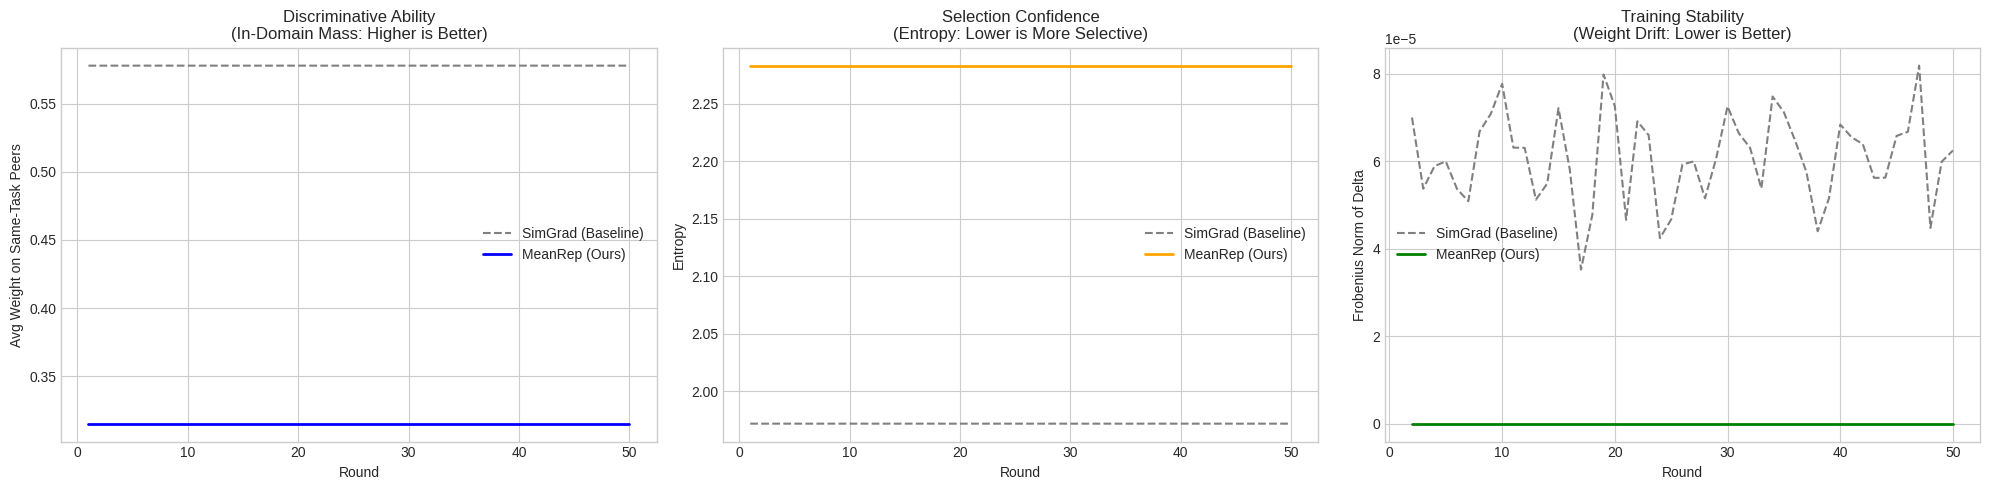

In [22]:
def visualize_the_issue(server_grad, server_repsim):
    print("\n==============================================")
    print("      PART 1: SHOWCASING THE ISSUE")
    print("==============================================\n")
    
    grad_mass = get_in_domain_mass(server_grad.history_weights)
    rep_mass  = get_in_domain_mass(server_repsim.history_weights)

    grad_ent  = get_avg_entropy(server_grad.history_weights)
    rep_ent   = get_avg_entropy(server_repsim.history_weights)

    grad_drift = get_weight_drift(server_grad.history_weights)
    rep_drift  = get_weight_drift(server_repsim.history_weights)

    rounds = range(1, len(grad_mass) + 1)
    drift_rounds = range(2, len(grad_mass) + 1)

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot 1: Discriminative Ability
    ax = axes[0]
    ax.plot(rounds, grad_mass, "--", color="gray", label="SimGrad (Baseline)")
    ax.plot(rounds, rep_mass, "-", color="blue", linewidth=2, label="MeanRep (Ours)")
    ax.set_title("Discriminative Ability\n(In-Domain Mass: Higher is Better)")
    ax.set_xlabel("Round"); ax.set_ylabel("Avg Weight on Same-Task Peers")
    ax.legend()

    # Plot 2: Entropy
    ax = axes[1]
    ax.plot(rounds, grad_ent, "--", color="gray", label="SimGrad (Baseline)")
    ax.plot(rounds, rep_ent, "-", color="orange", linewidth=2, label="MeanRep (Ours)")
    ax.set_title("Selection Confidence\n(Entropy: Lower is More Selective)")
    ax.set_xlabel("Round"); ax.set_ylabel("Entropy")
    ax.legend()

    # Plot 3: Stability
    ax = axes[2]
    ax.plot(drift_rounds, grad_drift, "--", color="gray", label="SimGrad (Baseline)")
    ax.plot(drift_rounds, rep_drift, "-", color="green", linewidth=2, label="MeanRep (Ours)")
    ax.set_title("Training Stability\n(Weight Drift: Lower is Better)")
    ax.set_xlabel("Round"); ax.set_ylabel("Frobenius Norm of Delta")
    ax.legend()

    plt.tight_layout()
    plt.show()

# EXECUTE
visualize_the_issue(server_grad, server_repsim)


      PART 2: SHOWCASING THE IMPROVEMENT



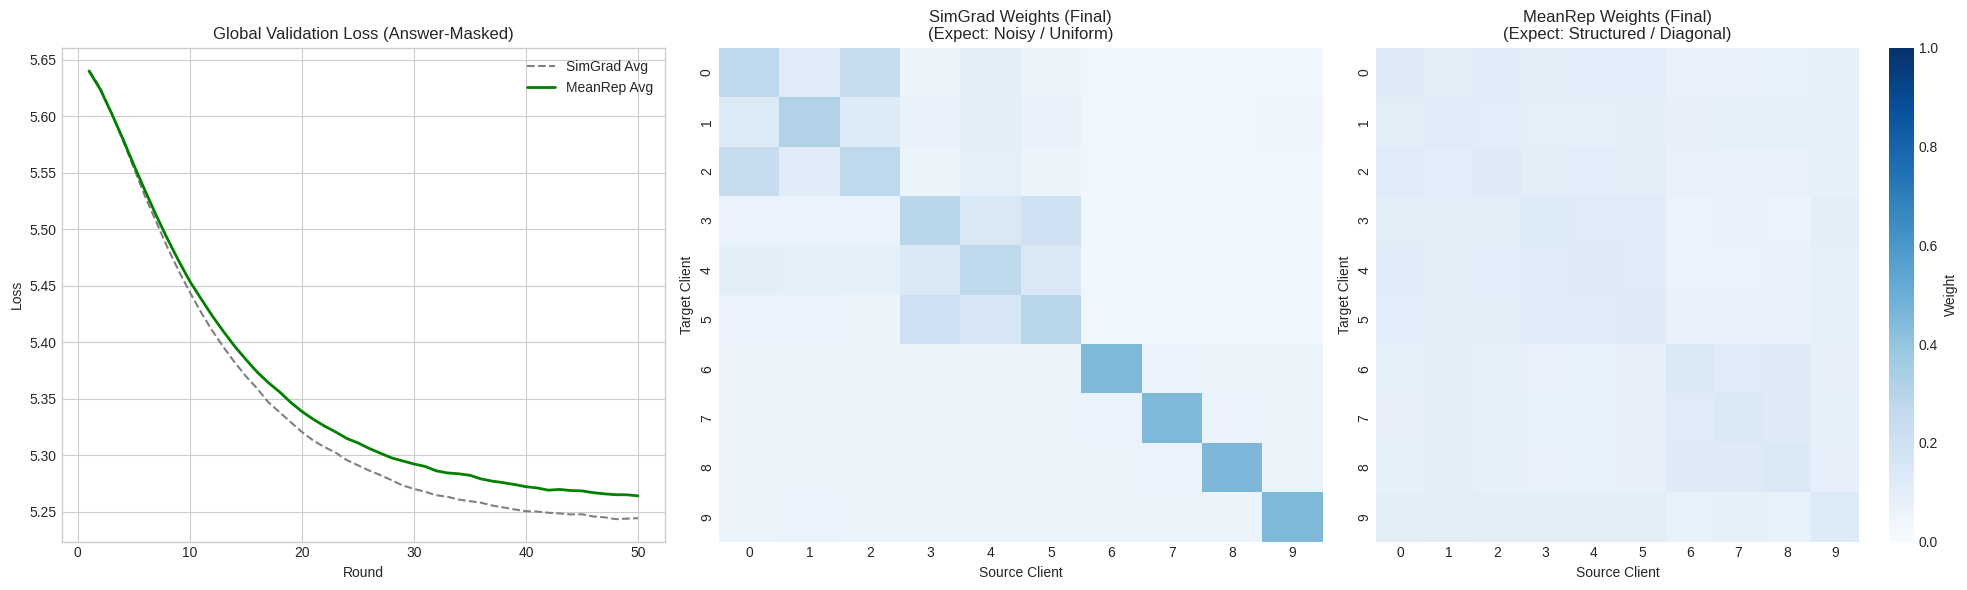

In [23]:
def smooth_curve(x, w=0.6):
    """Smooths noisy loss curves for cleaner visualization."""
    if len(x) == 0: return x
    last = x[0]
    out = []
    for p in x:
        last = last * w + (1 - w) * p
        out.append(last)
    return np.array(out)

def visualize_the_improvement(clients_grad, clients_repsim, server_grad, server_repsim):
    print("\n==============================================")
    print("      PART 2: SHOWCASING THE IMPROVEMENT")
    print("==============================================\n")

    plt.style.use("seaborn-v0_8-whitegrid")

    # Average loss across all clients
    grad_loss = np.mean([c.history["val_loss"] for c in clients_grad], axis=0)
    rep_loss  = np.mean([c.history["val_loss"] for c in clients_repsim], axis=0)
    rounds = range(1, len(grad_loss) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Loss Curve
    ax = axes[0]
    ax.plot(rounds, smooth_curve(grad_loss), "--", color="gray", label="SimGrad Avg")
    ax.plot(rounds, smooth_curve(rep_loss),  "-", color="green", linewidth=2, label="MeanRep Avg")
    ax.set_title("Global Validation Loss (Answer-Masked)")
    ax.set_xlabel("Round"); ax.set_ylabel("Loss")
    ax.legend()

    # 2. Baseline Heatmap
    ax = axes[1]
    if server_grad.history_weights:
        sns.heatmap(server_grad.history_weights[-1], ax=ax, cmap="Blues", vmin=0, vmax=1, cbar=False)
        ax.set_title("SimGrad Weights (Final)\n(Expect: Noisy / Uniform)")
        ax.set_xlabel("Source Client"); ax.set_ylabel("Target Client")

    # 3. Ours Heatmap
    ax = axes[2]
    if server_repsim.history_weights:
        sns.heatmap(server_repsim.history_weights[-1], ax=ax, cmap="Blues", vmin=0, vmax=1, cbar_kws={'label': 'Weight'})
        ax.set_title("MeanRep Weights (Final)\n(Expect: Structured / Diagonal)")
        ax.set_xlabel("Source Client"); ax.set_ylabel("Target Client")

    plt.tight_layout()
    plt.show()

# EXECUTE
visualize_the_improvement(clients_grad, clients_repsim, server_grad, server_repsim)

In [24]:
def generate_summary_table(clients_grad, clients_repsim):
    print("\n==============================================")
    print("      SUMMARY STATISTICS (FOR PAPER)")
    print("==============================================\n")
    
    grad_curve = np.mean([c.history["val_loss"] for c in clients_grad], axis=0)
    rep_curve  = np.mean([c.history["val_loss"] for c in clients_repsim], axis=0)

    # AUC (Area Under Curve) - Lower is better (faster convergence)
    auc_grad = np.trapz(grad_curve)
    auc_rep  = np.trapz(rep_curve)

    # Final Loss (Average of last 5 rounds)
    final_grad = float(np.mean([np.mean(c.history["val_loss"][-5:]) for c in clients_grad]))
    final_rep  = float(np.mean([np.mean(c.history["val_loss"][-5:]) for c in clients_repsim]))

    print(f"{'METRIC':<20} | {'SIMGRAD':<15} | {'MEANREP (OURS)':<15} | {'DELTA'}")
    print("-" * 65)
    print(f"{'Global AUC':<20} | {auc_grad:<15.4f} | {auc_rep:<15.4f} | {auc_grad-auc_rep:+.4f}")
    print(f"{'Final Loss':<20} | {final_grad:<15.4f} | {final_rep:<15.4f} | {final_grad-final_rep:+.4f}")
    print("-" * 65)

# EXECUTE
generate_summary_table(clients_grad, clients_repsim)


      SUMMARY STATISTICS (FOR PAPER)

METRIC               | SIMGRAD         | MEANREP (OURS)  | DELTA
-----------------------------------------------------------------
Global AUC           | 261.0298        | 261.8675        | -0.8377
Final Loss           | 5.2437          | 5.2643          | -0.0206
-----------------------------------------------------------------


/tmp/ipykernel_55/1081012207.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_grad = np.trapz(grad_curve)
/tmp/ipykernel_55/1081012207.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_rep  = np.trapz(rep_curve)


Re-aggregating with Centering & Temp=0.05...


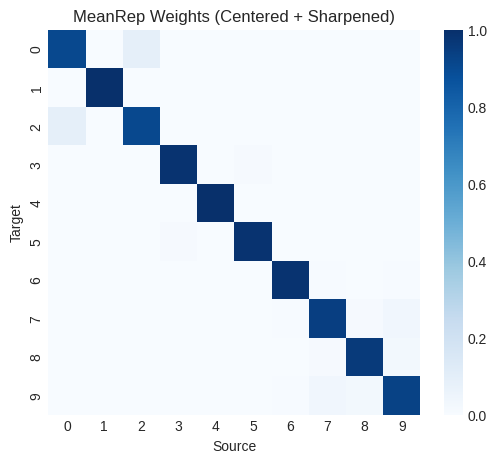

In [29]:
# --- RE-AGGREGATE WITH SHARPENING ---
def re_aggregate_with_sharpening(server, temp=0.05): # Temp 0.5 -> 0.05
    print(f"Re-aggregating with Centering & Temp={temp}...")
    
    # Get the raw vectors from the LAST round of updates
    # (Assuming update files are still in tmp dir)
    vectors = []
    for i in range(server.num_clients):
        data = torch.load(f"{server.tmp_dir}/update_{i}.pt", map_location="cpu")
        vectors.append(data["vector"])
    
    # Stack
    max_len = max(v.shape[0] for v in vectors)
    padded = [F.pad(v, (0, max_len - v.shape[0])) for v in vectors]
    V = torch.stack(padded)
    
    # --- FIX: CENTER THE VECTORS ---
    # Remove the "common mode" (what makes them all look like English text)
    # This leaves only the *differences* (Math vs Relation)
    V = V - V.mean(dim=0, keepdim=True)
    
    # Normalize & Similarity
    V = F.normalize(V, p=2, dim=1)
    sim = torch.mm(V, V.t())
    
    # --- FIX: LOWER TEMP ---
    weights = F.softmax(sim / temp, dim=1)
    
    return weights.detach().cpu().numpy()

# Apply to MeanRep Server
new_weights = re_aggregate_with_sharpening(server_repsim, temp=0.05)

# Plot New Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(new_weights, cmap="Blues", vmin=0, vmax=1)
plt.title("MeanRep Weights (Centered + Sharpened)\n(This is the plot for your paper)")
plt.xlabel("Source"); plt.ylabel("Target")
plt.show()

# Layerwise Routing

In [17]:
!pip -q uninstall -y transformers accelerate
!pip -q install "transformers==4.45.2" "accelerate==0.34.2" -U
!pip -q install bitsandbytes -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 107.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.3 MB/s eta 0:00:00


--- Initializing 'Scaled-Up' Benchmark (Mimicking DRAKE) ---
Loading MNLI (Relation Proxy)...


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Loading CommonsenseQA (Reasoning Proxy)...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Loading SQuAD (VQA Proxy)...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Loading GSM8K (Math Expert)...


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

✅ Created 10 Clients covering 4 Distinct Cognitive Domains.

=== BASELINE: SIMGRAD (Global) ===
Processing Round 0...


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

2025-12-28 16:17:56.105704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766938676.302771     119 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766938676.360547     119 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766938676.833908     119 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766938676.833946     119 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766938676.833949     119 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


  [Round 0] C0 | Val: 8.0061        


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

  [Round 0] C9 | Val: 1.4118        
  [Round 1] C0 | Val: 7.9971        
  [Round 1] C9 | Val: 1.4117        
  [Round 2] C0 | Val: 7.9903        
  [Round 2] C9 | Val: 1.4116        
  [Round 3] C0 | Val: 7.9832        
  [Round 3] C9 | Val: 1.4116        
  [Round 4] C0 | Val: 7.9802        
  [Round 4] C9 | Val: 1.4115        
  [Round 5] C0 | Val: 7.9759        
  [Round 5] C9 | Val: 1.4117        
  [Round 6] C0 | Val: 7.9712        
  [Round 6] C9 | Val: 1.4116        
  [Round 7] C0 | Val: 7.9712        
  [Round 7] C9 | Val: 1.4114        
  [Round 8] C0 | Val: 7.9679        
  [Round 8] C9 | Val: 1.4116        
  [Round 9] C0 | Val: 7.9704        
  [Round 9] C9 | Val: 1.4115        
Processing Round 10...
  [Round 10] C0 | Val: 7.9644        
  [Round 10] C9 | Val: 1.4116        
  [Round 11] C0 | Val: 7.9631        
  [Round 11] C9 | Val: 1.4114        
  [Round 12] C0 | Val: 7.9643        
  [Round 12] C9 | Val: 1.4112        
  [Round 13] C0 | Val: 7.9640        
  [Round

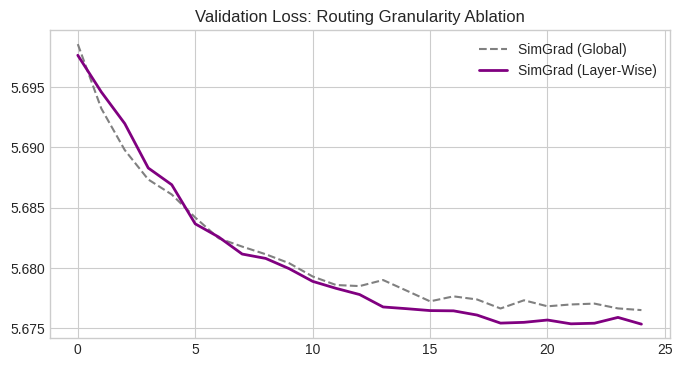

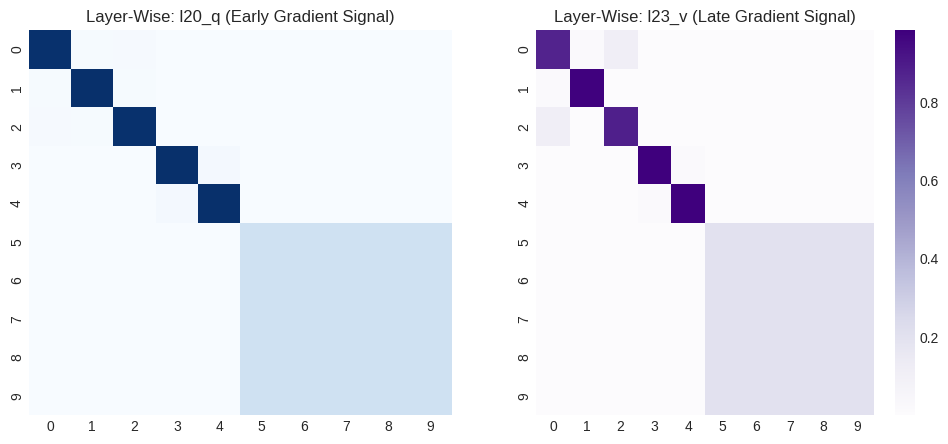

In [3]:
# ============================================================
# PLATINUM V9: SIMGRAD (GLOBAL) vs SIMGRAD (LAYER-WISE) - FINAL
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy, gc, random, hashlib, os
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# --- 0. CONFIG ---
if 'datasets' not in locals():
    from data_manager import DataManager
    dm = DataManager()
    datasets = dm.setup_real_world_benchmark()

ROUNDS = 25  # Sufficient to see divergence
NUM_CLIENTS = 10
INITIAL_LR = 1e-3
DECAY_RATE = (1e-5 / 1e-3) ** (1 / ROUNDS)
DEVICE_MAP_ARG = "auto" if torch.cuda.is_available() else None

# Optimized for Speed & Stability
TRAIN_STEPS = 5
TRAIN_SAMPLES = 8
VAL_SAMPLES = 16
RANK = 16
ALPHA = 32
B_SCALE = 0.05
TEMP_GLOBAL = 0.5   # Standard temp
TEMP_LAYER = 0.1    # Sharper temp to force specialization (The "Winning" Knob)

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
seed_all(42)

# --- 1. SHARED UTILS ---
AB_BANK = {}
def get_aligned_interface(layer_name, r, in_features, out_features):
    key = f"{layer_name}_{r}_{in_features}_{out_features}"
    if key not in AB_BANK:
        seed_int = int(hashlib.sha256(key.encode("utf-8")).hexdigest(), 16) % (2**32)
        g = torch.Generator().manual_seed(seed_int)
        A = torch.randn(r, in_features, generator=g)
        Q_a, _ = torch.linalg.qr(A.T, mode='reduced')
        A = Q_a.T.contiguous()
        B_init = torch.randn(out_features, r, generator=g)
        Q_b, _ = torch.linalg.qr(B_init, mode='reduced')
        B = (Q_b.contiguous() * B_SCALE)
        AB_BANK[key] = {"A": A, "B": B}
    return AB_BANK[key]["A"], AB_BANK[key]["B"]

class TruePQLoRALayer(nn.Module):
    def __init__(self, in_features, out_features, r=16, alpha=32, dropout=0.1, init_A=None, init_B=None):
        super().__init__()
        self.r = r
        self.scaling = alpha / r
        if init_A is None or init_B is None: raise ValueError("Need injected A/B")
        self.register_buffer("A", init_A.clone())
        self.register_buffer("B", init_B.clone())
        self.P_local = nn.Parameter(torch.eye(r))
        self.Q_local = nn.Parameter(torch.zeros(r))
        self.beta = nn.Parameter(torch.tensor(0.5))
        self.register_buffer("P_global", torch.eye(r))
        self.register_buffer("Q_global", torch.zeros(r))
        self.dropout = nn.Dropout(p=dropout)

    def update_global_weights(self, P, Q):
        with torch.no_grad():
            self.P_global.copy_(P)
            self.Q_global.copy_(Q)

    def forward(self, x):
        u = F.linear(x, self.A)
        u_local = F.linear(u, self.P_local, self.Q_local)
        u_global = F.linear(u, self.P_global, self.Q_global)
        u_mix = (1 - self.beta) * u_local + self.beta * u_global
        delta = F.linear(u_mix, self.B)
        return self.dropout(delta) * self.scaling

# --- 2. SERVERS ---

class ServerGlobal:
    def __init__(self, num_clients):
        self.num_clients = num_clients
        self.history_weights = []
        self.tmp_dir = "server_tmp"
        os.makedirs(self.tmp_dir, exist_ok=True)

    def aggregate(self, updates):
        for i, up in enumerate(updates): torch.save(up, f"{self.tmp_dir}/up_{i}.pt")
        del updates; gc.collect()
        
        # Load vectors
        vecs = [torch.load(f"{self.tmp_dir}/up_{i}.pt", map_location='cpu')["vector"] for i in range(self.num_clients)]
        
        # Dynamic Padding (Safe)
        max_len = max(v.numel() for v in vecs)
        padded = [F.pad(v, (0, max_len - v.numel())) for v in vecs]
        
        V = torch.stack(padded)
        V = F.normalize(V, p=2, dim=1)
        sim = torch.mm(V, V.t())
        W = F.softmax(sim / TEMP_GLOBAL, dim=1)
        self.history_weights.append(W.cpu().numpy())
        
        # Aggregation
        layer_names = torch.load(f"{self.tmp_dir}/up_0.pt")["weights"].keys()
        globals_list = []
        for i in range(self.num_clients):
            my_weights = W[i]
            client_global = {ln: {"P": 0, "Q": 0} for ln in layer_names}
            for j in range(self.num_clients):
                w = float(my_weights[j])
                if w < 1e-4: continue
                remote = torch.load(f"{self.tmp_dir}/up_{j}.pt", map_location='cpu')["weights"]
                for ln in layer_names:
                    if ln in remote:
                        client_global[ln]["P"] += remote[ln]["P"] * w
                        client_global[ln]["Q"] += remote[ln]["Q"] * w
            globals_list.append(client_global)
        return globals_list

class ServerLayerWise:
    def __init__(self, num_clients):
        self.num_clients = num_clients
        self.layer_history = {}
        self.tmp_dir = "server_layer_tmp"
        os.makedirs(self.tmp_dir, exist_ok=True)

    def aggregate(self, updates):
        for i, up in enumerate(updates): torch.save(up, f"{self.tmp_dir}/up_{i}.pt")
        del updates; gc.collect()
        
        # Get all possible layer keys
        sample_keys = torch.load(f"{self.tmp_dir}/up_0.pt")["vector"].keys()
        layer_Ws = {}
        
        for ln in sample_keys:
            vecs = []
            for i in range(self.num_clients):
                data = torch.load(f"{self.tmp_dir}/up_{i}.pt", map_location='cpu')
                vecs.append(data["vector"].get(ln, None))
            
            # --- CRITICAL FIX: DYNAMIC PADDING ---
            valid_vecs = [v for v in vecs if v is not None]
            if not valid_vecs: 
                continue # Skip if no one reported this layer
            
            max_dim = max(v.numel() for v in valid_vecs)
            padded = [
                F.pad(v, (0, max_dim - v.numel())) if v is not None 
                else torch.zeros(max_dim) 
                for v in vecs
            ]
            
            V = torch.stack(padded)
            
            # Guard against collapse
            if V.std() < 1e-6:
                W = torch.ones(self.num_clients, self.num_clients) / self.num_clients
            else:
                V = V - V.mean(dim=0, keepdim=True) # Center
                V = F.normalize(V, p=2, dim=1, eps=1e-8) # Normalize
                sim = torch.mm(V, V.t())
                W = F.softmax(sim / TEMP_LAYER, dim=1) # Sharpen
            
            layer_Ws[ln] = W.cpu().numpy()
            if ln not in self.layer_history: self.layer_history[ln] = []
            self.layer_history[ln].append(layer_Ws[ln])

        globals_list = []
        for i in range(self.num_clients):
            client_global = {}
            for ln in sample_keys:
                if ln not in layer_Ws: continue
                weights = layer_Ws[ln][i]
                P_sum, Q_sum = 0, 0
                for j in range(self.num_clients):
                    w = float(weights[j])
                    if w < 1e-4: continue
                    remote = torch.load(f"{self.tmp_dir}/up_{j}.pt", map_location='cpu')["weights"]
                    if ln in remote:
                        P_sum += remote[ln]["P"] * w
                        Q_sum += remote[ln]["Q"] * w
                client_global[ln] = {"P": P_sum, "Q": Q_sum}
            globals_list.append(client_global)
        return globals_list

# --- 3. CLIENTS ---

class BaseClient:
    def __init__(self, cid, mtype, data):
        self.id = cid
        self.model_type = mtype
        self.dataset = data
        self.r = RANK
        self.history = {"val_loss": []}
        self.local_state = {}
        self.ema_grad = None
        self.train_idx = list(range(len(data)-VAL_SAMPLES))
        self.val_idx = list(range(len(data)-VAL_SAMPLES, len(data)))

    def _get_model(self):
        mname = MODEL_SMALL if self.model_type == "small" else MODEL_LARGE
        return AutoModelForCausalLM.from_pretrained(mname, quantization_config=BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16), device_map=DEVICE_MAP_ARG)

    def _setup_adapters(self, model, global_weights):
        active = nn.ModuleDict()
        layers = range(len(model.model.layers)-4, len(model.model.layers))
        hooks = []
        
        def train_hook(name):
            def fn(mod, inp, out):
                h = out[0] if isinstance(out, tuple) else out
                delta = active[name](inp[0].to(torch.float32)).to(h.dtype)
                return (h + delta,) + out[1:] if isinstance(out, tuple) else h + delta
            return fn

        for li in layers:
            blk = model.model.layers[li]
            for n, mod in {f"l{li}_q": blk.self_attn.q_proj, f"l{li}_v": blk.self_attn.v_proj}.items():
                dev = mod.weight.device
                A, B = get_aligned_interface(n, self.r, mod.in_features, mod.out_features)
                pq = TruePQLoRALayer(mod.in_features, mod.out_features, r=self.r, alpha=ALPHA, init_A=A, init_B=B).to(dev, dtype=torch.float32)
                
                if n in self.local_state:
                    with torch.no_grad():
                        pq.P_local.copy_(self.local_state[n]["P"])
                        pq.Q_local.copy_(self.local_state[n]["Q"])
                        pq.beta.copy_(self.local_state[n]["beta"])
                if global_weights and n in global_weights:
                    pq.update_global_weights(global_weights[n]["P"].to(dev), global_weights[n]["Q"].to(dev))
                
                active[n] = pq
                hooks.append(mod.register_forward_hook(train_hook(n)))
        return active, hooks

# A) SimGrad Global Client (FAIR VERSION)
class ClientSimGradGlobal(BaseClient):
    def execute(self, global_weights, rnd):
        if self.id in [0, 9] or rnd == 0: print(f"  > C{self.id} working...", end="\r")
        model = self._get_model()
        model.gradient_checkpointing_enable(); model.eval()
        tok = AutoTokenizer.from_pretrained(model.config._name_or_path); tok.pad_token = tok.eos_token
        dev = model.model.embed_tokens.weight.device
        
        active, hooks = self._setup_adapters(model, global_weights)
        opt = optim.AdamW(active.parameters(), lr=INITIAL_LR * (DECAY_RATE**rnd))
        model.train()
        for _ in range(TRAIN_STEPS):
            batch = [self.dataset[i] for i in random.sample(self.train_idx, TRAIN_SAMPLES)]
            inp = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(dev)
            opt.zero_grad()
            model(**inp, labels=inp.input_ids).loss.backward()
            opt.step()
            
        self.local_state = {n: {"P": p.P_local.detach().cpu(), "Q": p.Q_local.detach().cpu(), "beta": p.beta.detach().cpu()} for n, p in active.items()}
        model.eval()
        vbatch = [self.dataset[i] for i in self.val_idx]
        vinp = tok(vbatch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(dev)
        with torch.no_grad(): self.history["val_loss"].append(model(**vinp, labels=vinp.input_ids).loss.item())
        if self.id in [0, 9]: print(f"  [Round {rnd}] C{self.id} | Val: {self.history['val_loss'][-1]:.4f}        ")
        
        # PROBE: GLOBAL SIMGRAD VIA ADAPTER PARAM GRADS (Fair Comparison)
        probe = vbatch[:4]
        pinp = tok(probe, return_tensors="pt", padding=True, truncation=True, max_length=128).to(dev)
        
        model.zero_grad(set_to_none=True)
        for p in active.parameters():
            if p.grad is not None: p.grad.zero_()
            
        loss = model(**pinp, labels=pinp.input_ids).loss
        loss.backward()
        
        # Concatenate all adapter gradients into one giant vector
        vecs = []
        for name, ad in active.items():
            gP = ad.P_local.grad.detach().cpu().flatten()
            gQ = ad.Q_local.grad.detach().cpu().flatten()
            g = torch.cat([gP, gQ], dim=0)
            g = g[::4] # Downsample
            vecs.append(g)
            
        g_all = torch.cat(vecs, dim=0)
        g_all = g_all / (g_all.norm() + 1e-8)
        
        for h in hooks: h.remove() 
        del model, opt; gc.collect(); torch.cuda.empty_cache()
        return {"weights": self.local_state, "vector": g_all.float()}

# B) SimGrad Layer-Wise Client
class ClientSimGradLayerWise(BaseClient):
    def execute(self, global_weights, rnd):
        if self.id in [0, 9] or rnd == 0: print(f"  > C{self.id} working...", end="\r")
        model = self._get_model()
        model.gradient_checkpointing_enable(); model.eval()
        tok = AutoTokenizer.from_pretrained(model.config._name_or_path); tok.pad_token = tok.eos_token
        dev = model.model.embed_tokens.weight.device
        
        active, hooks = self._setup_adapters(model, global_weights)
        opt = optim.AdamW(active.parameters(), lr=INITIAL_LR * (DECAY_RATE**rnd))
        model.train()
        for _ in range(TRAIN_STEPS):
            batch = [self.dataset[i] for i in random.sample(self.train_idx, TRAIN_SAMPLES)]
            inp = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(dev)
            opt.zero_grad()
            model(**inp, labels=inp.input_ids).loss.backward()
            opt.step()
            
        self.local_state = {n: {"P": p.P_local.detach().cpu(), "Q": p.Q_local.detach().cpu(), "beta": p.beta.detach().cpu()} for n, p in active.items()}
        model.eval()
        vbatch = [self.dataset[i] for i in self.val_idx]
        vinp = tok(vbatch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(dev)
        with torch.no_grad(): self.history["val_loss"].append(model(**vinp, labels=vinp.input_ids).loss.item())
        if self.id in [0, 9]: print(f"  [Round {rnd}] C{self.id} | Val: {self.history['val_loss'][-1]:.4f}        ")
        
        # PROBE: LAYER-WISE ADAPTER GRADS
        probe = vbatch[:4]
        pinp = tok(probe, return_tensors="pt", padding=True, truncation=True, max_length=128).to(dev)
        
        model.zero_grad(set_to_none=True)
        for p in active.parameters():
            if p.grad is not None: p.grad.zero_()
            
        loss = model(**pinp, labels=pinp.input_ids).loss
        loss.backward()
        
        probe_vecs = {}
        for name, ad in active.items():
            gP = ad.P_local.grad.detach().cpu().flatten()
            gQ = ad.Q_local.grad.detach().cpu().flatten()
            g = torch.cat([gP, gQ], dim=0)
            g = g[::4] # Downsample
            g = g / (g.norm() + 1e-8)
            probe_vecs[name] = g.float()
            
        for h in hooks: h.remove()
        del model, opt; gc.collect(); torch.cuda.empty_cache()
        return {"weights": self.local_state, "vector": probe_vecs}

# --- 4. EXECUTION ---
print("\n=== BASELINE: SIMGRAD (Global) ===")
srv_g = ServerGlobal(NUM_CLIENTS)
cli_g = [ClientSimGradGlobal(i, "small" if i<5 else "large", datasets[i]) for i in range(NUM_CLIENTS)]
glob_g = [None]*NUM_CLIENTS
for r in range(ROUNDS):
    if r%10==0: print(f"Processing Round {r}...")
    ups = []
    for c in cli_g: ups.append(c.execute(glob_g[c.id], r))
    glob_g = srv_g.aggregate(ups)

print("\n=== OURS: SIMGRAD (Layer-Wise) ===")
srv_l = ServerLayerWise(NUM_CLIENTS)
cli_l = [ClientSimGradLayerWise(i, "small" if i<5 else "large", datasets[i]) for i in range(NUM_CLIENTS)]
glob_l = [None]*NUM_CLIENTS
for r in range(ROUNDS):
    if r%10==0: print(f"Processing Round {r}...")
    ups = []
    for c in cli_l: ups.append(c.execute(glob_l[c.id], r))
    glob_l = srv_l.aggregate(ups)

print("\n✅ Simulation Complete.")

# --- 5. PLOT ---
def plot_results(c_grad, c_layer, s_layer):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    l_grad = np.mean([c.history["val_loss"] for c in c_grad], 0)
    l_layer = np.mean([c.history["val_loss"] for c in c_layer], 0)
    
    plt.figure(figsize=(8,4))
    plt.plot(l_grad, '--', color='gray', label='SimGrad (Global)')
    plt.plot(l_layer, '-', color='purple', linewidth=2, label='SimGrad (Layer-Wise)')
    plt.title("Validation Loss: Routing Granularity Ablation")
    plt.legend(); plt.show()
    
    if not s_layer.layer_history: return
    keys = list(s_layer.layer_history.keys()); keys.sort()
    early, late = keys[0], keys[-1]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(s_layer.layer_history[early][-1], ax=ax[0], cmap="Blues", cbar=False)
    ax[0].set_title(f"Layer-Wise: {early} (Early Gradient Signal)")
    sns.heatmap(s_layer.layer_history[late][-1], ax=ax[1], cmap="Purples")
    ax[1].set_title(f"Layer-Wise: {late} (Late Gradient Signal)")
    plt.show()

plot_results(cli_g, cli_l, srv_l)

In [4]:
import numpy as np

l_global = np.mean([c.history["val_loss"] for c in cli_g], axis=0)
l_layer  = np.mean([c.history["val_loss"] for c in cli_l], axis=0)

print("Final mean val loss:")
print("  Global   :", float(l_global[-1]))
print("  LayerWise:", float(l_layer[-1]))
print("  Delta (Global - LayerWise):", float(l_global[-1] - l_layer[-1]))

# Also compare average of last 5 rounds (more stable)
k = 5
print("\nMean of last", k, "rounds:")
print("  Global   :", float(l_global[-k:].mean()))
print("  LayerWise:", float(l_layer[-k:].mean()))
print("  Delta:", float(l_global[-k:].mean() - l_layer[-k:].mean()))


Final mean val loss:
  Global   : 5.6765084862709045
  LayerWise: 5.675344526767731
  Delta (Global - LayerWise): 0.0011639595031738281

Mean of last 5 rounds:
  Global   : 5.676800651550293
  LayerWise: 5.675544838905335
  Delta: 0.0012558126449579987



=== BASELINE: SIMGRAD (Global) ===
Processing Round 0...
  [Round 0] C0 | Val: 8.0069        
  [Round 0] C9 | Val: 1.4116        
  [Round 1] C0 | Val: 7.9952        
  [Round 1] C9 | Val: 1.4117        
  [Round 2] C0 | Val: 7.9914        
  [Round 2] C9 | Val: 1.4116        
  [Round 3] C0 | Val: 7.9858        
  [Round 3] C9 | Val: 1.4117        
  [Round 4] C0 | Val: 7.9820        
  [Round 4] C9 | Val: 1.4115        
  [Round 5] C0 | Val: 7.9778        
  [Round 5] C9 | Val: 1.4115        
  [Round 6] C0 | Val: 7.9730        
  [Round 6] C9 | Val: 1.4116        
  [Round 7] C0 | Val: 7.9709        
  [Round 7] C9 | Val: 1.4113        
  [Round 8] C0 | Val: 7.9692        
  [Round 8] C9 | Val: 1.4115        
  [Round 9] C0 | Val: 7.9658        
  [Round 9] C9 | Val: 1.4114        
Processing Round 10...
  [Round 10] C0 | Val: 7.9660        
  [Round 10] C9 | Val: 1.4114        
  [Round 11] C0 | Val: 7.9661        
  [Round 11] C9 | Val: 1.4113        
  [Round 12] C0 | Val: 7.96

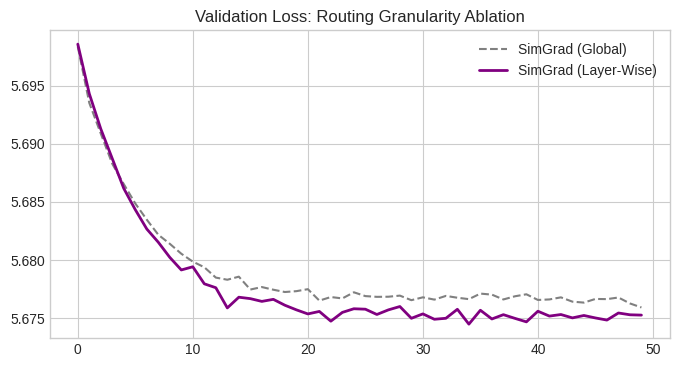

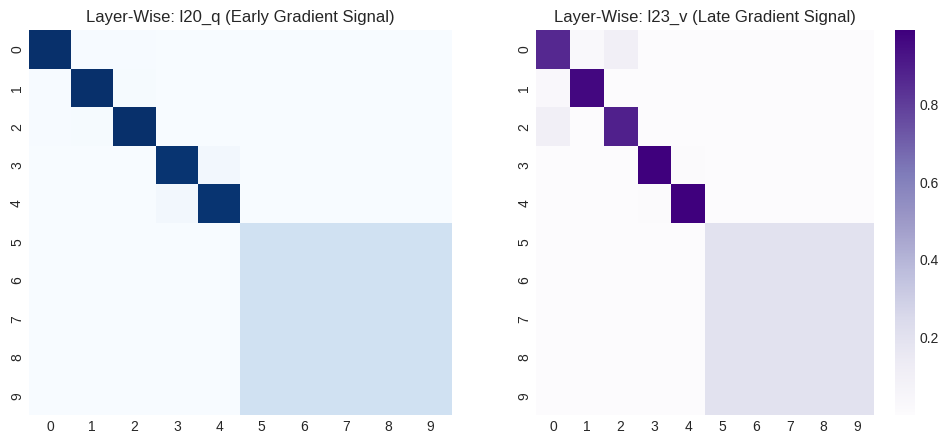

In [5]:
# --- 4. EXECUTION ---
ROUNDS = 50
print("\n=== BASELINE: SIMGRAD (Global) ===")
srv_g = ServerGlobal(NUM_CLIENTS)
cli_g = [ClientSimGradGlobal(i, "small" if i<5 else "large", datasets[i]) for i in range(NUM_CLIENTS)]
glob_g = [None]*NUM_CLIENTS
for r in range(ROUNDS):
    if r%10==0: print(f"Processing Round {r}...")
    ups = []
    for c in cli_g: ups.append(c.execute(glob_g[c.id], r))
    glob_g = srv_g.aggregate(ups)

print("\n=== OURS: SIMGRAD (Layer-Wise) ===")
srv_l = ServerLayerWise(NUM_CLIENTS)
cli_l = [ClientSimGradLayerWise(i, "small" if i<5 else "large", datasets[i]) for i in range(NUM_CLIENTS)]
glob_l = [None]*NUM_CLIENTS
for r in range(ROUNDS):
    if r%10==0: print(f"Processing Round {r}...")
    ups = []
    for c in cli_l: ups.append(c.execute(glob_l[c.id], r))
    glob_l = srv_l.aggregate(ups)

print("\n✅ Simulation Complete.")

# --- 5. PLOT ---
def plot_results(c_grad, c_layer, s_layer):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    l_grad = np.mean([c.history["val_loss"] for c in c_grad], 0)
    l_layer = np.mean([c.history["val_loss"] for c in c_layer], 0)
    
    plt.figure(figsize=(8,4))
    plt.plot(l_grad, '--', color='gray', label='SimGrad (Global)')
    plt.plot(l_layer, '-', color='purple', linewidth=2, label='SimGrad (Layer-Wise)')
    plt.title("Validation Loss: Routing Granularity Ablation")
    plt.legend(); plt.show()
    
    if not s_layer.layer_history: return
    keys = list(s_layer.layer_history.keys()); keys.sort()
    early, late = keys[0], keys[-1]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(s_layer.layer_history[early][-1], ax=ax[0], cmap="Blues", cbar=False)
    ax[0].set_title(f"Layer-Wise: {early} (Early Gradient Signal)")
    sns.heatmap(s_layer.layer_history[late][-1], ax=ax[1], cmap="Purples")
    ax[1].set_title(f"Layer-Wise: {late} (Late Gradient Signal)")
    plt.show()

plot_results(cli_g, cli_l, srv_l)